In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

cuda


# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'Circles'
#DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

[[  0 522]
 [  1 478]]
(1000, 1, 28, 28)
torch.Size([160, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 656 ms, sys: 123 ms, total: 779 ms
Wall time: 602 ms


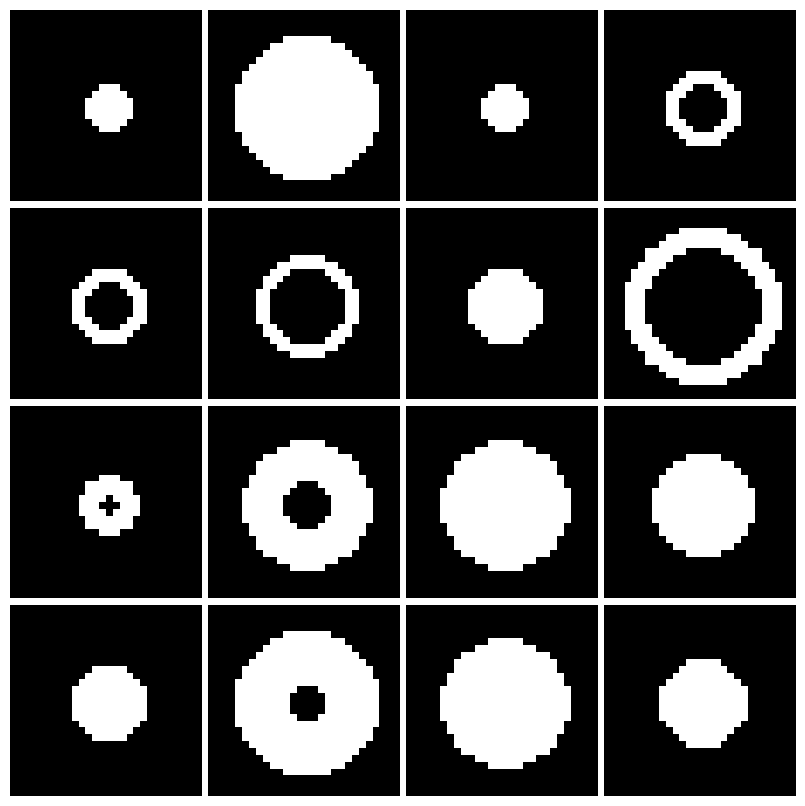

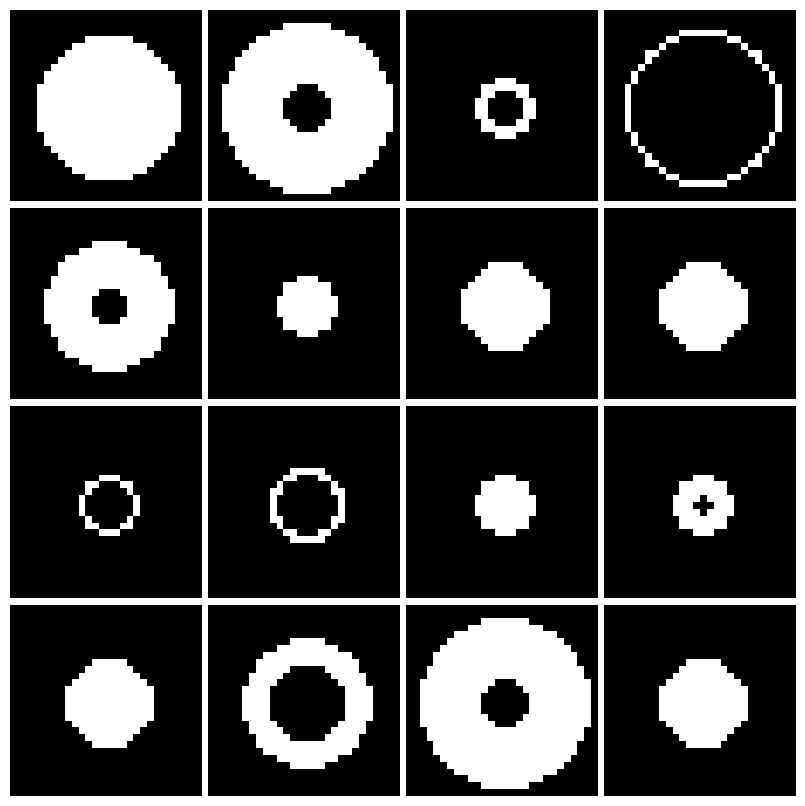

In [4]:
%%time

if DATA_SET == 'Circles' :
    img_size = 28
    
    shapes, targets = gen_circles_dataset(num_images=1000, image_size=img_size, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, img_size, img_size) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

# train_dataset = torch.bernoulli(train_dataset)
# eval_dataset = torch.bernoulli(eval_dataset)

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([160, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2260) tensor(0.4182)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2477) tensor(0.4317)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, img_size, img_size),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-2
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 124 µs, sys: 0 ns, total: 124 µs
Wall time: 128 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=300,
    learning_rate=1e-4,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

callbacks = []
history_cb = TrainHistoryCallback()
callbacks.append(history_cb)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-10_17-31-52. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 300
 - per_device_train_batch_size: 160
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7febc088f4c0>

Successfully launched training !



Training of epoch 1/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 569.6241
Eval loss: 546.8481
--------------------------------------------------------------------------


Training of epoch 2/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 566.0851
Eval loss: 546.3333
--------------------------------------------------------------------------


Training of epoch 3/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 561.4003
Eval loss: 545.1933
--------------------------------------------------------------------------


Training of epoch 4/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 558.4875
Eval loss: 541.6445
--------------------------------------------------------------------------


Training of epoch 5/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 555.7551
Eval loss: 541.1943
--------------------------------------------------------------------------


Training of epoch 6/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 551.6208
Eval loss: 538.2189
--------------------------------------------------------------------------


Training of epoch 7/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 545.1543
Eval loss: 536.2915
--------------------------------------------------------------------------


Training of epoch 8/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 542.0202
Eval loss: 534.1611
--------------------------------------------------------------------------


Training of epoch 9/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 540.0087
Eval loss: 532.7144
--------------------------------------------------------------------------


Training of epoch 10/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 536.5103
Eval loss: 530.904
--------------------------------------------------------------------------


Training of epoch 11/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 533.9982
Eval loss: 528.1161
--------------------------------------------------------------------------


Training of epoch 12/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 532.353
Eval loss: 526.6219
--------------------------------------------------------------------------


Training of epoch 13/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 526.1083
Eval loss: 523.1467
--------------------------------------------------------------------------


Training of epoch 14/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 525.1859
Eval loss: 522.1396
--------------------------------------------------------------------------


Training of epoch 15/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 521.665
Eval loss: 521.4625
--------------------------------------------------------------------------


Training of epoch 16/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 518.4838
Eval loss: 516.7589
--------------------------------------------------------------------------


Training of epoch 17/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 516.3475
Eval loss: 516.0998
--------------------------------------------------------------------------


Training of epoch 18/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 512.4216
Eval loss: 513.1507
--------------------------------------------------------------------------


Training of epoch 19/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 510.6196
Eval loss: 510.5915
--------------------------------------------------------------------------


Training of epoch 20/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 509.5336
Eval loss: 510.3393
--------------------------------------------------------------------------


Training of epoch 21/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 506.4841
Eval loss: 506.8059
--------------------------------------------------------------------------


Training of epoch 22/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 502.887
Eval loss: 502.7711
--------------------------------------------------------------------------


Training of epoch 23/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 501.8639
Eval loss: 501.3646
--------------------------------------------------------------------------


Training of epoch 24/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 498.6724
Eval loss: 500.44
--------------------------------------------------------------------------


Training of epoch 25/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 495.3089
Eval loss: 499.3774
--------------------------------------------------------------------------


Training of epoch 26/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 492.5639
Eval loss: 495.9878
--------------------------------------------------------------------------


Training of epoch 27/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 488.6843
Eval loss: 491.6826
--------------------------------------------------------------------------


Training of epoch 28/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 487.3638
Eval loss: 488.1619
--------------------------------------------------------------------------


Training of epoch 29/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 481.4622
Eval loss: 488.9678
--------------------------------------------------------------------------


Training of epoch 30/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 479.4068
Eval loss: 486.4832
--------------------------------------------------------------------------


Training of epoch 31/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 480.5391
Eval loss: 478.6895
--------------------------------------------------------------------------


Training of epoch 32/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 476.3138
Eval loss: 477.5645
--------------------------------------------------------------------------


Training of epoch 33/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 473.9565
Eval loss: 478.458
--------------------------------------------------------------------------


Training of epoch 34/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 468.522
Eval loss: 468.2655
--------------------------------------------------------------------------


Training of epoch 35/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 471.0469
Eval loss: 476.641
--------------------------------------------------------------------------


Training of epoch 36/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 462.4653
Eval loss: 475.1746
--------------------------------------------------------------------------


Training of epoch 37/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 456.5525
Eval loss: 465.8795
--------------------------------------------------------------------------


Training of epoch 38/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 451.6982
Eval loss: 467.051
--------------------------------------------------------------------------


Training of epoch 39/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 449.4772
Eval loss: 460.9802
--------------------------------------------------------------------------


Training of epoch 40/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 446.5651
Eval loss: 454.5749
--------------------------------------------------------------------------


Training of epoch 41/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 442.2397
Eval loss: 449.6166
--------------------------------------------------------------------------


Training of epoch 42/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 438.5461
Eval loss: 446.5963
--------------------------------------------------------------------------


Training of epoch 43/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 436.5786
Eval loss: 438.9924
--------------------------------------------------------------------------


Training of epoch 44/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 435.8347
Eval loss: 435.1063
--------------------------------------------------------------------------


Training of epoch 45/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 426.7922
Eval loss: 439.9089
--------------------------------------------------------------------------


Training of epoch 46/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 419.6248
Eval loss: 427.0274
--------------------------------------------------------------------------


Training of epoch 47/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 414.6705
Eval loss: 425.3116
--------------------------------------------------------------------------


Training of epoch 48/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 410.1202
Eval loss: 423.4055
--------------------------------------------------------------------------


Training of epoch 49/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 405.7894
Eval loss: 419.8343
--------------------------------------------------------------------------


Training of epoch 50/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 406.6572
Eval loss: 416.5097
--------------------------------------------------------------------------


Training of epoch 51/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 403.5715
Eval loss: 416.0843
--------------------------------------------------------------------------


Training of epoch 52/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 403.0561
Eval loss: 406.501
--------------------------------------------------------------------------


Training of epoch 53/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 394.8928
Eval loss: 409.828
--------------------------------------------------------------------------


Training of epoch 54/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 382.3392
Eval loss: 401.3922
--------------------------------------------------------------------------


Training of epoch 55/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 388.9558
Eval loss: 390.7188
--------------------------------------------------------------------------


Training of epoch 56/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 388.2885
Eval loss: 388.882
--------------------------------------------------------------------------


Training of epoch 57/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 380.1677
Eval loss: 396.0342
--------------------------------------------------------------------------


Training of epoch 58/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 382.0096
Eval loss: 365.2536
--------------------------------------------------------------------------


Training of epoch 59/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 373.355
Eval loss: 388.103
--------------------------------------------------------------------------


Training of epoch 60/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 370.2513
Eval loss: 371.6598
--------------------------------------------------------------------------


Training of epoch 61/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 364.3965
Eval loss: 365.2333
--------------------------------------------------------------------------


Training of epoch 62/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 364.2364
Eval loss: 352.7878
--------------------------------------------------------------------------


Training of epoch 63/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 365.1563
Eval loss: 352.4655
--------------------------------------------------------------------------


Training of epoch 64/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 360.4084
Eval loss: 367.501
--------------------------------------------------------------------------


Training of epoch 65/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 356.1234
Eval loss: 370.3852
--------------------------------------------------------------------------


Training of epoch 66/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 353.4558
Eval loss: 346.0165
--------------------------------------------------------------------------


Training of epoch 67/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 348.2464
Eval loss: 348.5329
--------------------------------------------------------------------------


Training of epoch 68/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 341.9934
Eval loss: 343.4328
--------------------------------------------------------------------------


Training of epoch 69/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 342.9038
Eval loss: 364.1531
--------------------------------------------------------------------------


Training of epoch 70/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 341.5045
Eval loss: 348.4851
--------------------------------------------------------------------------


Training of epoch 71/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 336.8218
Eval loss: 333.2094
--------------------------------------------------------------------------


Training of epoch 72/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 326.2179
Eval loss: 349.2832
--------------------------------------------------------------------------


Training of epoch 73/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 328.6845
Eval loss: 330.3366
--------------------------------------------------------------------------


Training of epoch 74/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 329.4149
Eval loss: 340.0378
--------------------------------------------------------------------------


Training of epoch 75/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 325.6248
Eval loss: 324.4096
--------------------------------------------------------------------------


Training of epoch 76/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 324.5555
Eval loss: 341.8525
--------------------------------------------------------------------------


Training of epoch 77/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 331.39
Eval loss: 343.2227
--------------------------------------------------------------------------


Training of epoch 78/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 322.6227
Eval loss: 329.5103
--------------------------------------------------------------------------


Training of epoch 79/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 319.981
Eval loss: 320.4277
--------------------------------------------------------------------------


Training of epoch 80/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 310.024
Eval loss: 321.1549
--------------------------------------------------------------------------


Training of epoch 81/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 311.3832
Eval loss: 309.884
--------------------------------------------------------------------------


Training of epoch 82/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 305.7911
Eval loss: 309.6892
--------------------------------------------------------------------------


Training of epoch 83/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 314.9141
Eval loss: 321.5839
--------------------------------------------------------------------------


Training of epoch 84/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 302.4547
Eval loss: 309.5585
--------------------------------------------------------------------------


Training of epoch 85/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 299.9597
Eval loss: 310.0783
--------------------------------------------------------------------------


Training of epoch 86/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 298.537
Eval loss: 298.3377
--------------------------------------------------------------------------


Training of epoch 87/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 311.1272
Eval loss: 300.8296
--------------------------------------------------------------------------


Training of epoch 88/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 292.4844
Eval loss: 316.1162
--------------------------------------------------------------------------


Training of epoch 89/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 303.7606
Eval loss: 303.7708
--------------------------------------------------------------------------


Training of epoch 90/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 295.5793
Eval loss: 298.2549
--------------------------------------------------------------------------


Training of epoch 91/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 287.8163
Eval loss: 300.7167
--------------------------------------------------------------------------


Training of epoch 92/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 286.291
Eval loss: 290.9788
--------------------------------------------------------------------------


Training of epoch 93/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 288.3135
Eval loss: 298.5373
--------------------------------------------------------------------------


Training of epoch 94/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 286.0049
Eval loss: 299.3904
--------------------------------------------------------------------------


Training of epoch 95/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 289.4343
Eval loss: 287.5507
--------------------------------------------------------------------------


Training of epoch 96/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 282.5564
Eval loss: 285.8285
--------------------------------------------------------------------------


Training of epoch 97/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 288.242
Eval loss: 277.6122
--------------------------------------------------------------------------


Training of epoch 98/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 277.9444
Eval loss: 276.9739
--------------------------------------------------------------------------


Training of epoch 99/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 279.6717
Eval loss: 281.8176
--------------------------------------------------------------------------


Training of epoch 100/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 284.1941
Eval loss: 275.3078
--------------------------------------------------------------------------


Training of epoch 101/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 276.096
Eval loss: 276.0005
--------------------------------------------------------------------------


Training of epoch 102/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 276.0894
Eval loss: 261.8593
--------------------------------------------------------------------------


Training of epoch 103/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 266.1048
Eval loss: 270.0771
--------------------------------------------------------------------------


Training of epoch 104/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 265.7408
Eval loss: 269.3144
--------------------------------------------------------------------------


Training of epoch 105/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 264.9972
Eval loss: 278.0977
--------------------------------------------------------------------------


Training of epoch 106/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 256.5504
Eval loss: 259.6938
--------------------------------------------------------------------------


Training of epoch 107/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 265.8363
Eval loss: 252.6276
--------------------------------------------------------------------------


Training of epoch 108/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 253.2495
Eval loss: 261.4362
--------------------------------------------------------------------------


Training of epoch 109/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 256.4756
Eval loss: 243.6794
--------------------------------------------------------------------------


Training of epoch 110/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 246.3197
Eval loss: 261.2157
--------------------------------------------------------------------------


Training of epoch 111/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 249.3714
Eval loss: 237.1698
--------------------------------------------------------------------------


Training of epoch 112/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 250.0177
Eval loss: 253.5015
--------------------------------------------------------------------------


Training of epoch 113/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 251.5056
Eval loss: 256.3913
--------------------------------------------------------------------------


Training of epoch 114/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 243.8834
Eval loss: 241.8815
--------------------------------------------------------------------------


Training of epoch 115/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 246.9798
Eval loss: 241.3618
--------------------------------------------------------------------------


Training of epoch 116/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 237.675
Eval loss: 231.4722
--------------------------------------------------------------------------


Training of epoch 117/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 237.5451
Eval loss: 222.4765
--------------------------------------------------------------------------


Training of epoch 118/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 236.5003
Eval loss: 226.8651
--------------------------------------------------------------------------


Training of epoch 119/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 225.7805
Eval loss: 241.393
--------------------------------------------------------------------------


Training of epoch 120/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 236.9304
Eval loss: 229.5618
--------------------------------------------------------------------------


Training of epoch 121/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 222.402
Eval loss: 236.4445
--------------------------------------------------------------------------


Training of epoch 122/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 233.4617
Eval loss: 216.9812
--------------------------------------------------------------------------


Training of epoch 123/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 216.8168
Eval loss: 220.2444
--------------------------------------------------------------------------


Training of epoch 124/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 217.3489
Eval loss: 215.5667
--------------------------------------------------------------------------


Training of epoch 125/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 219.2293
Eval loss: 210.09
--------------------------------------------------------------------------


Training of epoch 126/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 218.5527
Eval loss: 213.1689
--------------------------------------------------------------------------


Training of epoch 127/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.229
Eval loss: 207.7561
--------------------------------------------------------------------------


Training of epoch 128/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 206.3712
Eval loss: 197.322
--------------------------------------------------------------------------


Training of epoch 129/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 208.8203
Eval loss: 191.0062
--------------------------------------------------------------------------


Training of epoch 130/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 209.0234
Eval loss: 208.2236
--------------------------------------------------------------------------


Training of epoch 131/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 205.5343
Eval loss: 203.6102
--------------------------------------------------------------------------


Training of epoch 132/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 199.1995
Eval loss: 200.4125
--------------------------------------------------------------------------


Training of epoch 133/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.3634
Eval loss: 202.3459
--------------------------------------------------------------------------


Training of epoch 134/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.8155
Eval loss: 204.8986
--------------------------------------------------------------------------


Training of epoch 135/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.5348
Eval loss: 190.5578
--------------------------------------------------------------------------


Training of epoch 136/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.7973
Eval loss: 194.5495
--------------------------------------------------------------------------


Training of epoch 137/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.3342
Eval loss: 195.3681
--------------------------------------------------------------------------


Training of epoch 138/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.2195
Eval loss: 190.1191
--------------------------------------------------------------------------


Training of epoch 139/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.8538
Eval loss: 190.2649
--------------------------------------------------------------------------


Training of epoch 140/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.8897
Eval loss: 187.9336
--------------------------------------------------------------------------


Training of epoch 141/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.6597
Eval loss: 188.2606
--------------------------------------------------------------------------


Training of epoch 142/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.8052
Eval loss: 186.4529
--------------------------------------------------------------------------


Training of epoch 143/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.7827
Eval loss: 183.7979
--------------------------------------------------------------------------


Training of epoch 144/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.3342
Eval loss: 191.4287
--------------------------------------------------------------------------


Training of epoch 145/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.6684
Eval loss: 185.8652
--------------------------------------------------------------------------


Training of epoch 146/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.8618
Eval loss: 192.5645
--------------------------------------------------------------------------


Training of epoch 147/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7259
Eval loss: 173.1979
--------------------------------------------------------------------------


Training of epoch 148/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.072
Eval loss: 170.9053
--------------------------------------------------------------------------


Training of epoch 149/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.9076
Eval loss: 179.2389
--------------------------------------------------------------------------


Training of epoch 150/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7492
Eval loss: 176.2582
--------------------------------------------------------------------------


Training of epoch 151/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.8627
Eval loss: 179.0005
--------------------------------------------------------------------------


Training of epoch 152/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.1675
Eval loss: 173.8651
--------------------------------------------------------------------------


Training of epoch 153/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.2291
Eval loss: 179.1886
--------------------------------------------------------------------------


Training of epoch 154/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.7414
Eval loss: 174.6804
--------------------------------------------------------------------------


Training of epoch 155/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.1089
Eval loss: 174.1194
--------------------------------------------------------------------------


Training of epoch 156/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.7126
Eval loss: 167.5958
--------------------------------------------------------------------------


Training of epoch 157/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.7105
Eval loss: 169.5976
--------------------------------------------------------------------------


Training of epoch 158/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.9918
Eval loss: 167.6671
--------------------------------------------------------------------------


Training of epoch 159/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.6743
Eval loss: 167.6032
--------------------------------------------------------------------------


Training of epoch 160/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.283
Eval loss: 158.1089
--------------------------------------------------------------------------


Training of epoch 161/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.6027
Eval loss: 169.0802
--------------------------------------------------------------------------


Training of epoch 162/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.4003
Eval loss: 161.2126
--------------------------------------------------------------------------


Training of epoch 163/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.8898
Eval loss: 163.8697
--------------------------------------------------------------------------


Training of epoch 164/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.6667
Eval loss: 162.7679
--------------------------------------------------------------------------


Training of epoch 165/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 153.0554
Eval loss: 157.703
--------------------------------------------------------------------------


Training of epoch 166/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 155.141
Eval loss: 159.0405
--------------------------------------------------------------------------


Training of epoch 167/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 152.362
Eval loss: 156.9293
--------------------------------------------------------------------------


Training of epoch 168/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.0491
Eval loss: 169.7717
--------------------------------------------------------------------------


Training of epoch 169/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 149.4753
Eval loss: 154.5861
--------------------------------------------------------------------------


Training of epoch 170/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.782
Eval loss: 154.0191
--------------------------------------------------------------------------


Training of epoch 171/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 149.8721
Eval loss: 153.2358
--------------------------------------------------------------------------


Training of epoch 172/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 149.0454
Eval loss: 153.9079
--------------------------------------------------------------------------


Training of epoch 173/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 147.1099
Eval loss: 156.6693
--------------------------------------------------------------------------


Training of epoch 174/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 149.0983
Eval loss: 158.0481
--------------------------------------------------------------------------


Training of epoch 175/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.058
Eval loss: 155.6445
--------------------------------------------------------------------------


Training of epoch 176/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 147.9749
Eval loss: 154.0053
--------------------------------------------------------------------------


Training of epoch 177/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.4719
Eval loss: 152.966
--------------------------------------------------------------------------


Training of epoch 178/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.8538
Eval loss: 158.133
--------------------------------------------------------------------------


Training of epoch 179/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 143.4055
Eval loss: 149.5162
--------------------------------------------------------------------------


Training of epoch 180/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 142.8414
Eval loss: 151.6839
--------------------------------------------------------------------------


Training of epoch 181/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.4343
Eval loss: 148.9757
--------------------------------------------------------------------------


Training of epoch 182/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.2076
Eval loss: 154.262
--------------------------------------------------------------------------


Training of epoch 183/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.184
Eval loss: 139.8767
--------------------------------------------------------------------------


Training of epoch 184/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.6697
Eval loss: 146.4637
--------------------------------------------------------------------------


Training of epoch 185/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 138.999
Eval loss: 150.9504
--------------------------------------------------------------------------


Training of epoch 186/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.3935
Eval loss: 144.4135
--------------------------------------------------------------------------


Training of epoch 187/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.908
Eval loss: 151.5904
--------------------------------------------------------------------------


Training of epoch 188/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.0915
Eval loss: 140.6444
--------------------------------------------------------------------------


Training of epoch 189/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.1709
Eval loss: 145.8506
--------------------------------------------------------------------------


Training of epoch 190/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.1727
Eval loss: 140.8311
--------------------------------------------------------------------------


Training of epoch 191/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.214
Eval loss: 142.597
--------------------------------------------------------------------------


Training of epoch 192/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.3632
Eval loss: 147.5349
--------------------------------------------------------------------------


Training of epoch 193/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.9476
Eval loss: 149.0762
--------------------------------------------------------------------------


Training of epoch 194/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 131.6191
Eval loss: 138.2351
--------------------------------------------------------------------------


Training of epoch 195/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 131.1542
Eval loss: 138.309
--------------------------------------------------------------------------


Training of epoch 196/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.8047
Eval loss: 144.0103
--------------------------------------------------------------------------


Training of epoch 197/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 133.6628
Eval loss: 150.4545
--------------------------------------------------------------------------


Training of epoch 198/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 129.406
Eval loss: 141.2935
--------------------------------------------------------------------------


Training of epoch 199/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.6268
Eval loss: 143.4293
--------------------------------------------------------------------------


Training of epoch 200/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.8491
Eval loss: 135.9056
--------------------------------------------------------------------------


Training of epoch 201/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 201/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.5033
Eval loss: 142.6086
--------------------------------------------------------------------------


Training of epoch 202/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 202/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.9104
Eval loss: 135.9753
--------------------------------------------------------------------------


Training of epoch 203/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 203/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.9464
Eval loss: 143.6631
--------------------------------------------------------------------------


Training of epoch 204/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 204/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.4988
Eval loss: 138.1656
--------------------------------------------------------------------------


Training of epoch 205/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 205/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1906
Eval loss: 135.1851
--------------------------------------------------------------------------


Training of epoch 206/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 206/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8694
Eval loss: 141.9735
--------------------------------------------------------------------------


Training of epoch 207/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 207/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3038
Eval loss: 140.6157
--------------------------------------------------------------------------


Training of epoch 208/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 208/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 120.005
Eval loss: 136.2218
--------------------------------------------------------------------------


Training of epoch 209/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 209/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.0671
Eval loss: 138.5839
--------------------------------------------------------------------------


Training of epoch 210/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 210/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5593
Eval loss: 134.8945
--------------------------------------------------------------------------


Training of epoch 211/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 211/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.1205
Eval loss: 130.9746
--------------------------------------------------------------------------


Training of epoch 212/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 212/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.3996
Eval loss: 143.6493
--------------------------------------------------------------------------


Training of epoch 213/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 213/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118.6313
Eval loss: 136.1387
--------------------------------------------------------------------------


Training of epoch 214/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 214/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 117.8455
Eval loss: 132.6376
--------------------------------------------------------------------------


Training of epoch 215/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 215/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 119.6983
Eval loss: 129.8671
--------------------------------------------------------------------------


Training of epoch 216/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 216/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 119.7354
Eval loss: 133.0172
--------------------------------------------------------------------------


Training of epoch 217/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 217/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 119.7036
Eval loss: 125.5905
--------------------------------------------------------------------------


Training of epoch 218/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 218/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 115.8321
Eval loss: 133.3101
--------------------------------------------------------------------------


Training of epoch 219/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 219/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 119.1593
Eval loss: 129.9667
--------------------------------------------------------------------------


Training of epoch 220/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 220/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.7563
Eval loss: 132.0301
--------------------------------------------------------------------------


Training of epoch 221/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 221/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 112.8533
Eval loss: 126.6064
--------------------------------------------------------------------------


Training of epoch 222/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 222/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.0689
Eval loss: 131.8679
--------------------------------------------------------------------------


Training of epoch 223/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 223/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 116.3988
Eval loss: 127.8734
--------------------------------------------------------------------------


Training of epoch 224/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 224/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.1245
Eval loss: 124.5169
--------------------------------------------------------------------------


Training of epoch 225/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 225/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.7205
Eval loss: 128.9939
--------------------------------------------------------------------------


Training of epoch 226/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 226/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.9778
Eval loss: 136.3812
--------------------------------------------------------------------------


Training of epoch 227/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 227/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 113.7622
Eval loss: 129.4483
--------------------------------------------------------------------------


Training of epoch 228/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 228/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 110.0316
Eval loss: 129.4979
--------------------------------------------------------------------------


Training of epoch 229/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 229/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 112.0265
Eval loss: 131.7387
--------------------------------------------------------------------------


Training of epoch 230/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 230/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 111.7606
Eval loss: 126.8526
--------------------------------------------------------------------------


Training of epoch 231/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 231/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 113.4475
Eval loss: 123.183
--------------------------------------------------------------------------


Training of epoch 232/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 232/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 111.7234
Eval loss: 127.5168
--------------------------------------------------------------------------


Training of epoch 233/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 233/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 111.6783
Eval loss: 127.5668
--------------------------------------------------------------------------


Training of epoch 234/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 234/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.8982
Eval loss: 121.4756
--------------------------------------------------------------------------


Training of epoch 235/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 235/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 110.6428
Eval loss: 126.3304
--------------------------------------------------------------------------


Training of epoch 236/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 236/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 108.8378
Eval loss: 122.0677
--------------------------------------------------------------------------


Training of epoch 237/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 237/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 110.7227
Eval loss: 119.9613
--------------------------------------------------------------------------


Training of epoch 238/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 238/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 107.7884
Eval loss: 121.4426
--------------------------------------------------------------------------


Training of epoch 239/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 239/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 108.5898
Eval loss: 127.2311
--------------------------------------------------------------------------


Training of epoch 240/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 240/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.21
Eval loss: 120.0727
--------------------------------------------------------------------------


Training of epoch 241/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 241/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 105.6099
Eval loss: 121.2224
--------------------------------------------------------------------------


Training of epoch 242/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 242/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.8
Eval loss: 122.8962
--------------------------------------------------------------------------


Training of epoch 243/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 243/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.8402
Eval loss: 129.1846
--------------------------------------------------------------------------


Training of epoch 244/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 244/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 108.6967
Eval loss: 121.1812
--------------------------------------------------------------------------


Training of epoch 245/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 245/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 105.1839
Eval loss: 122.3878
--------------------------------------------------------------------------


Training of epoch 246/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 246/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 105.7007
Eval loss: 118.9633
--------------------------------------------------------------------------


Training of epoch 247/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 247/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.2676
Eval loss: 119.9773
--------------------------------------------------------------------------


Training of epoch 248/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 248/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.868
Eval loss: 120.1674
--------------------------------------------------------------------------


Training of epoch 249/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 249/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 104.7025
Eval loss: 119.716
--------------------------------------------------------------------------


Training of epoch 250/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 250/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 104.3045
Eval loss: 115.1671
--------------------------------------------------------------------------


Training of epoch 251/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 251/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.2981
Eval loss: 120.3148
--------------------------------------------------------------------------


Training of epoch 252/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 252/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.504
Eval loss: 116.9541
--------------------------------------------------------------------------


Training of epoch 253/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 253/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.8814
Eval loss: 118.0502
--------------------------------------------------------------------------


Training of epoch 254/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 254/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 104.4155
Eval loss: 126.8819
--------------------------------------------------------------------------


Training of epoch 255/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 255/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.7781
Eval loss: 114.5253
--------------------------------------------------------------------------


Training of epoch 256/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 256/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.0109
Eval loss: 123.3173
--------------------------------------------------------------------------


Training of epoch 257/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 257/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 105.5053
Eval loss: 120.8591
--------------------------------------------------------------------------


Training of epoch 258/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 258/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.9594
Eval loss: 117.7746
--------------------------------------------------------------------------


Training of epoch 259/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 259/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.815
Eval loss: 120.3827
--------------------------------------------------------------------------


Training of epoch 260/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 260/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.5882
Eval loss: 120.7854
--------------------------------------------------------------------------


Training of epoch 261/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 261/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.9011
Eval loss: 115.7378
--------------------------------------------------------------------------


Training of epoch 262/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 262/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.7441
Eval loss: 117.8103
--------------------------------------------------------------------------


Training of epoch 263/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 263/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.2857
Eval loss: 112.1226
--------------------------------------------------------------------------


Training of epoch 264/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 264/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.7068
Eval loss: 120.7416
--------------------------------------------------------------------------


Training of epoch 265/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 265/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.9769
Eval loss: 114.7002
--------------------------------------------------------------------------


Training of epoch 266/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 266/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.1184
Eval loss: 111.1774
--------------------------------------------------------------------------


Training of epoch 267/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 267/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.4981
Eval loss: 117.1332
--------------------------------------------------------------------------


Training of epoch 268/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 268/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.1315
Eval loss: 118.3442
--------------------------------------------------------------------------


Training of epoch 269/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 269/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.8088
Eval loss: 116.2197
--------------------------------------------------------------------------


Training of epoch 270/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 270/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.4339
Eval loss: 111.8138
--------------------------------------------------------------------------


Training of epoch 271/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 271/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.1381
Eval loss: 115.2562
--------------------------------------------------------------------------


Training of epoch 272/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 272/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.8069
Eval loss: 114.1435
--------------------------------------------------------------------------


Training of epoch 273/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 273/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.1791
Eval loss: 114.3397
--------------------------------------------------------------------------


Training of epoch 274/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 274/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.5675
Eval loss: 115.5332
--------------------------------------------------------------------------


Training of epoch 275/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 275/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.8888
Eval loss: 116.2334
--------------------------------------------------------------------------


Training of epoch 276/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 276/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.2994
Eval loss: 115.1312
--------------------------------------------------------------------------


Training of epoch 277/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 277/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 98.3654
Eval loss: 110.6683
--------------------------------------------------------------------------


Training of epoch 278/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 278/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 98.4986
Eval loss: 112.8249
--------------------------------------------------------------------------


Training of epoch 279/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 279/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.6489
Eval loss: 108.756
--------------------------------------------------------------------------


Training of epoch 280/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 280/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.7507
Eval loss: 109.9834
--------------------------------------------------------------------------


Training of epoch 281/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 281/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.3008
Eval loss: 112.2547
--------------------------------------------------------------------------


Training of epoch 282/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 282/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 98.1943
Eval loss: 109.2606
--------------------------------------------------------------------------


Training of epoch 283/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 283/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.9835
Eval loss: 110.4527
--------------------------------------------------------------------------


Training of epoch 284/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 284/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.6622
Eval loss: 110.4139
--------------------------------------------------------------------------


Training of epoch 285/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 285/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.84
Eval loss: 113.2337
--------------------------------------------------------------------------


Training of epoch 286/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 286/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.3753
Eval loss: 107.9059
--------------------------------------------------------------------------


Training of epoch 287/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 287/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.32
Eval loss: 115.046
--------------------------------------------------------------------------


Training of epoch 288/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 288/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.1749
Eval loss: 113.8287
--------------------------------------------------------------------------


Training of epoch 289/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 289/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.4113
Eval loss: 109.7178
--------------------------------------------------------------------------


Training of epoch 290/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 290/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.5595
Eval loss: 105.9997
--------------------------------------------------------------------------


Training of epoch 291/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 291/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.2646
Eval loss: 114.7483
--------------------------------------------------------------------------


Training of epoch 292/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 292/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.8657
Eval loss: 111.5221
--------------------------------------------------------------------------


Training of epoch 293/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 293/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.4153
Eval loss: 114.8886
--------------------------------------------------------------------------


Training of epoch 294/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 294/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.1222
Eval loss: 104.7022
--------------------------------------------------------------------------


Training of epoch 295/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 295/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.8869
Eval loss: 105.9839
--------------------------------------------------------------------------


Training of epoch 296/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 296/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.1904
Eval loss: 107.7307
--------------------------------------------------------------------------


Training of epoch 297/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 297/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.0475
Eval loss: 110.3901
--------------------------------------------------------------------------


Training of epoch 298/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 298/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.9865
Eval loss: 110.9138
--------------------------------------------------------------------------


Training of epoch 299/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 299/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.8503
Eval loss: 108.3835
--------------------------------------------------------------------------


Training of epoch 300/300:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 300/300:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.2013
Eval loss: 111.5113
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-06-10_17-31-52/final_model


CPU times: user 52.7 s, sys: 1.77 s, total: 54.5 s
Wall time: 55.6 s


## Loss History

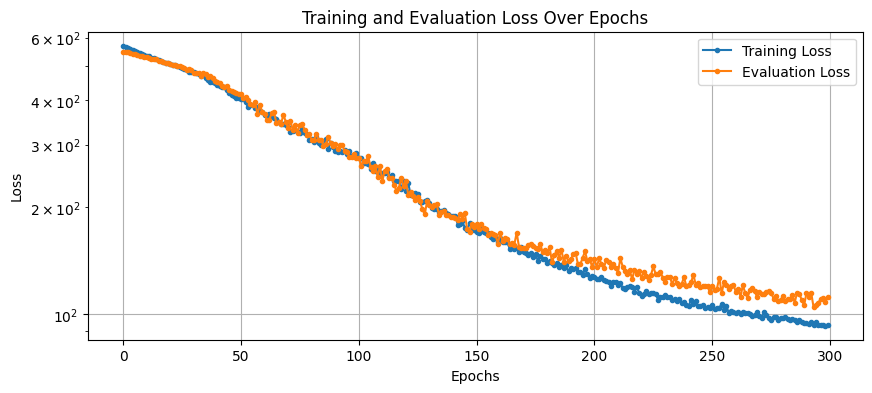

In [12]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(history_cb.history['train_loss'], label='Training Loss', marker='.')
plt.plot(history_cb.history['eval_loss'], label='Evaluation Loss', marker='.')

# Add titles and labels
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Trained Model

In [13]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

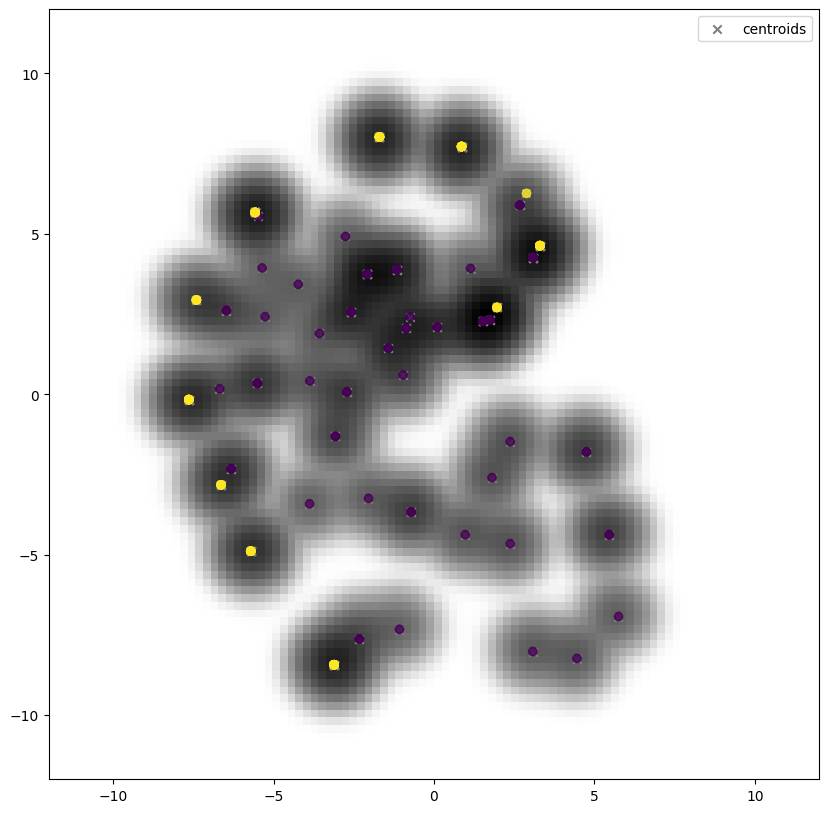

In [29]:
# You can also print the latent space when dealing with 2D latent spaces

train_latents = trained_model.encoder(train_dataset.to(device)).embedding.detach().cpu().numpy()
eval_latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

plt.figure(figsize=(10, 10))
lim=12

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

magn = (torch.sqrt(torch.det(trained_model.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(trained_model.centroids_tens[:, 0].detach().cpu().numpy(), trained_model.centroids_tens[:, 1].detach().cpu().numpy(), c='gray', label='centroids', marker='x')
#plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r', label='samples')
plt.scatter(train_latents[:, 0], train_latents[:, 1], c=train_labels, alpha=0.8)
#plt.scatter(eval_latents[:, 0], eval_latents[:, 1], c=eval_labels, alpha=0.8)

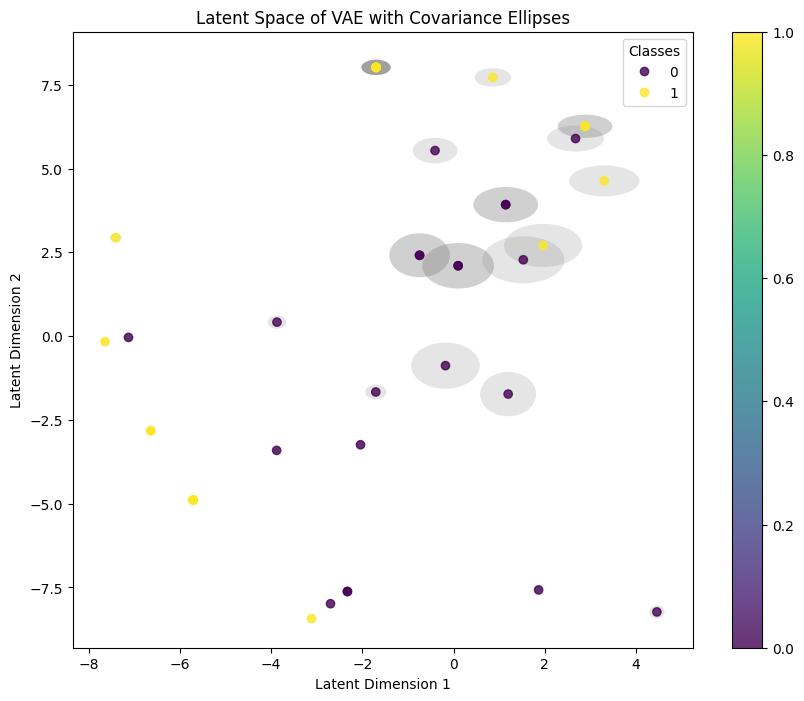

In [15]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.8)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

In [37]:
trained_model.centroids_tens.shape

torch.Size([160, 2])

In [17]:
trained_model
# 'centroids',
 # 'centroids_tens', 
 # 'metric', 
 # 'G',
 # 'G_inv',
 # 'M',
 # 'M_tens',
 # 'T_destination',

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)

# RECONSTRUCTIONS

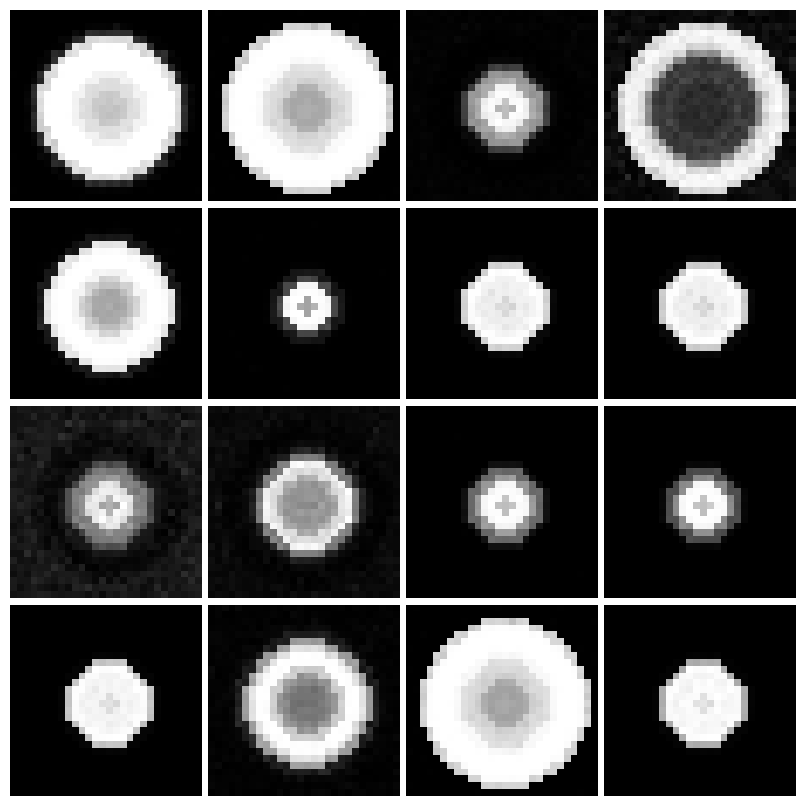

In [18]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

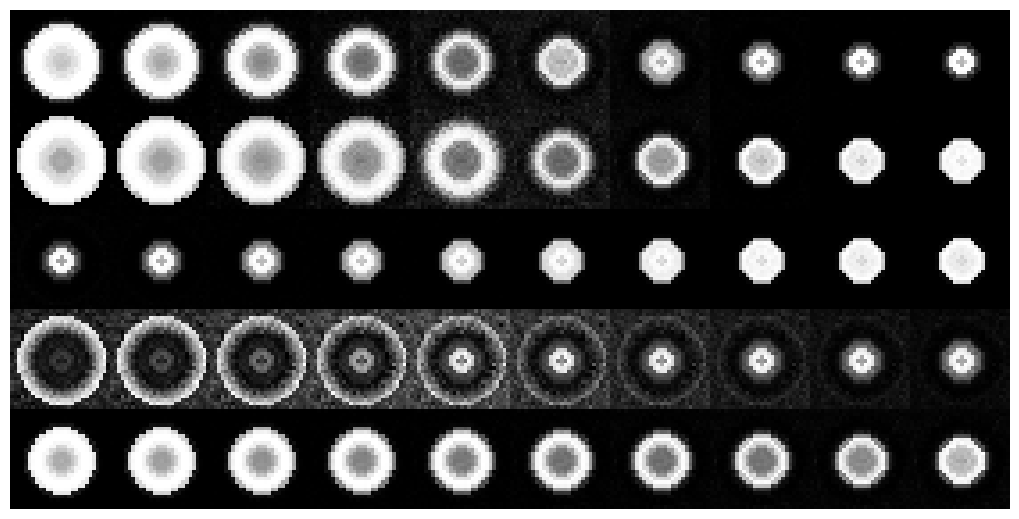

In [19]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [20]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, img_size, img_size)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, img_size, img_size).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, img_size, img_size).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [51]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 2.8100
IS [mean] = 2.5198
IS [std] = 0.2607


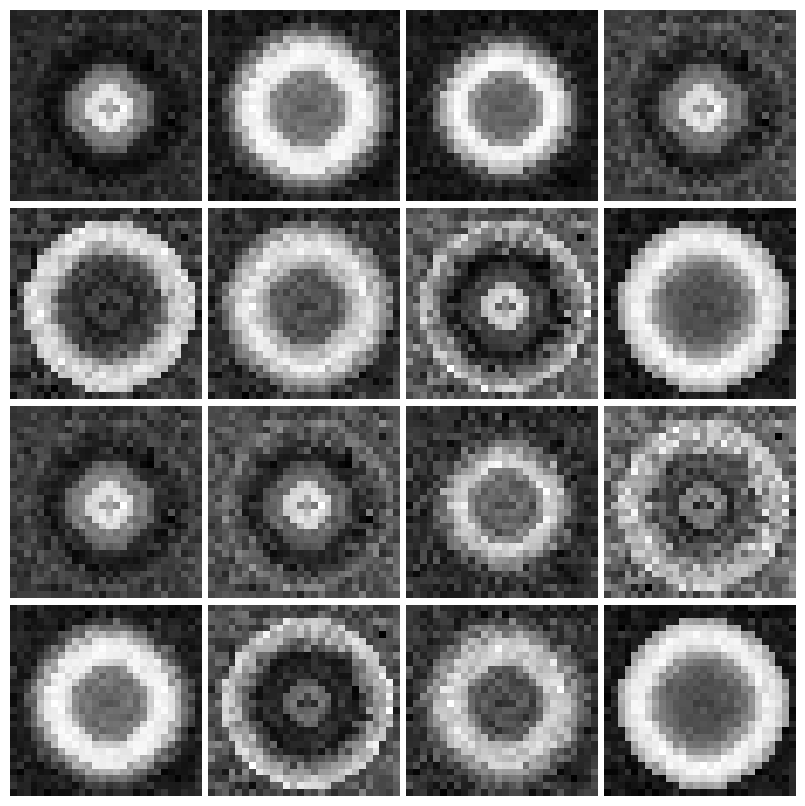

In [52]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

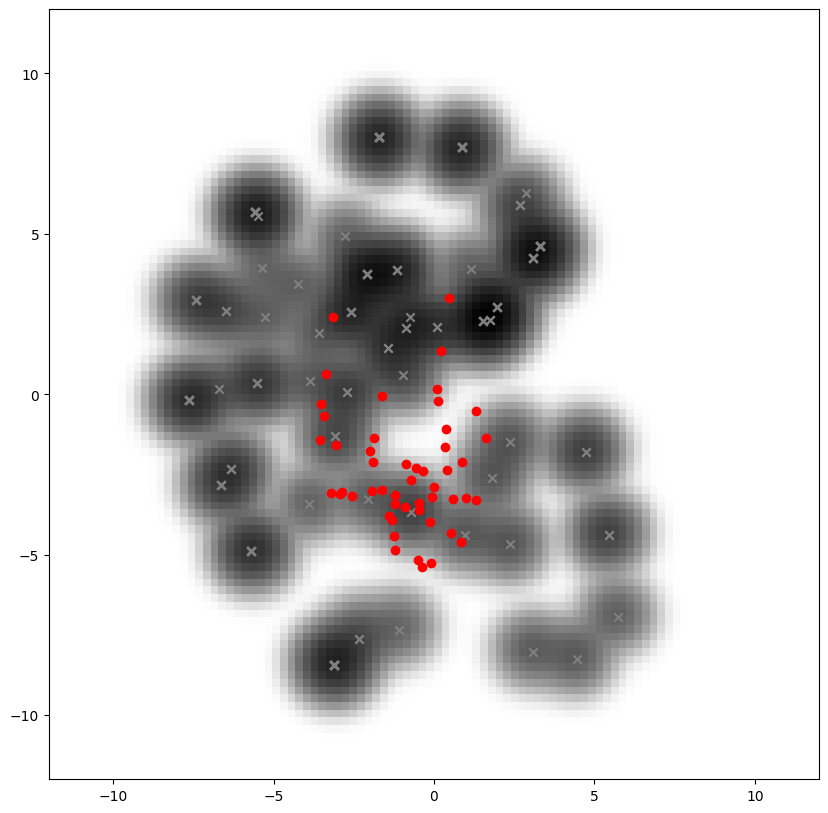

In [53]:
z_mean = trained_model.encoder(gen_data.to(device)).embedding.detach().cpu().numpy()

plt.figure(figsize=(10, 10))
lim=12

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

magn = (torch.sqrt(torch.det(trained_model.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(trained_model.centroids_tens[:, 0].detach().cpu().numpy(), trained_model.centroids_tens[:, 1].detach().cpu().numpy(), c='gray', label='centroids', marker='x')
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r', label='samples')

### Gaussian Mixture Model Sampler

In [44]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 2.6750
IS [mean] = 2.2461
IS [std] = 0.1754


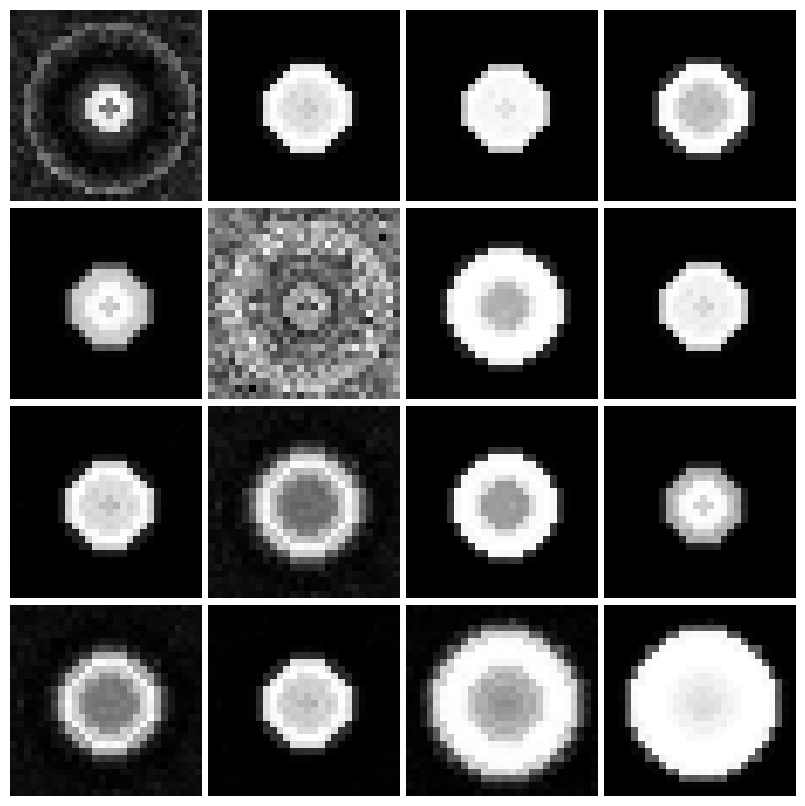

In [45]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

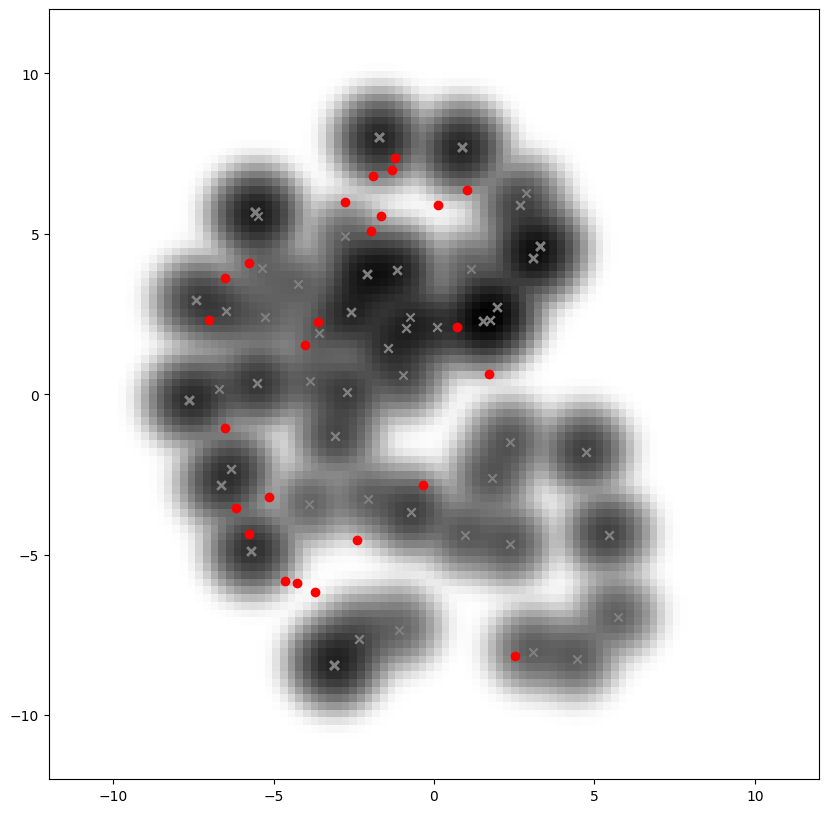

In [46]:
z_mean = trained_model.encoder(gmm_gen_data.to(device)).embedding.detach().cpu().numpy()

plt.figure(figsize=(10, 10))
lim=12

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

magn = (torch.sqrt(torch.det(trained_model.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(trained_model.centroids_tens[:, 0].detach().cpu().numpy(), trained_model.centroids_tens[:, 1].detach().cpu().numpy(), c='gray', label='centroids', marker='x')
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r', label='samples')
plt.legend()

### RHVAE Sampler

In [48]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 15,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 1.9580
IS [mean] = 2.3769
IS [std] = 0.2435


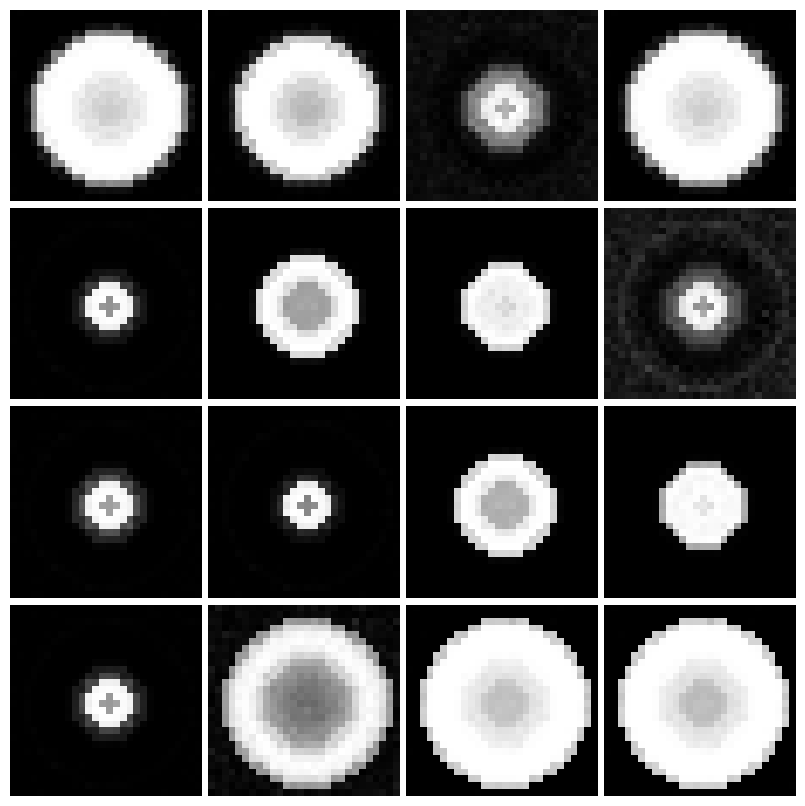

In [49]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)

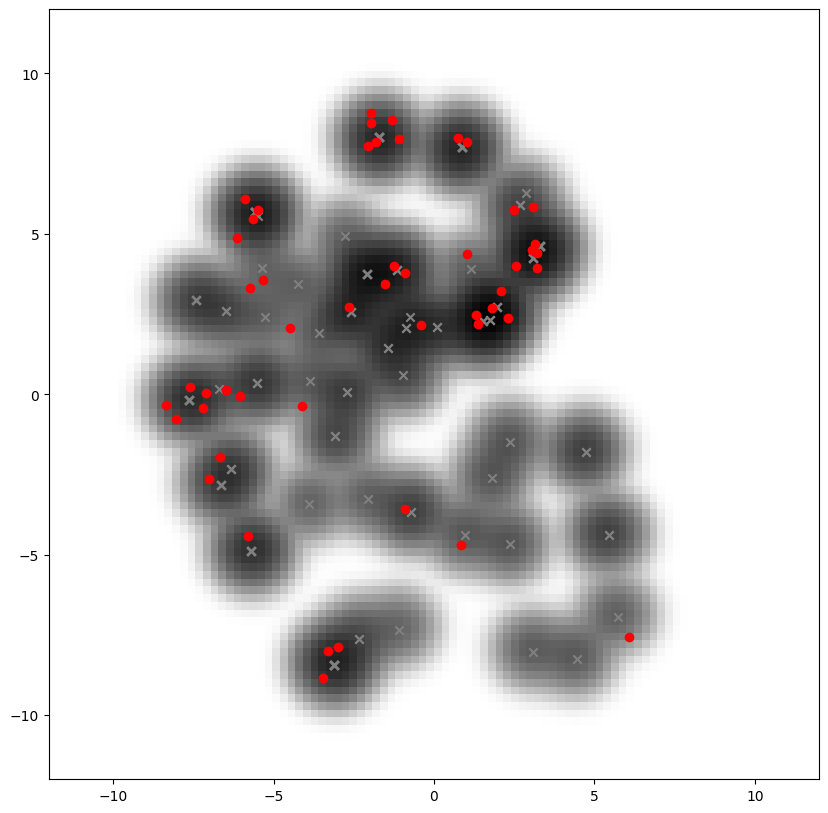

In [56]:
#z_mean = trained_model.encoder(rh_gen_data.to(device)).embedding.detach().cpu().numpy()
z_mean = rh_sampler.hmc_sampling(50).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
lim=12

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

magn = (torch.sqrt(torch.det(trained_model.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(trained_model.centroids_tens[:, 0].detach().cpu().numpy(), trained_model.centroids_tens[:, 1].detach().cpu().numpy(), c='gray', label='centroids', marker='x')
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r', label='samples')
plt.legend()